In [1]:
%matplotlib inline
import pandas as pd
import urllib as ur
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np

## Coletando a duração de cada viagem.

In [4]:
# Lendo csv de intervalos de ociosidade e ocupação
dfOccupied = pd.read_csv('../travels.csv')
dfParked = pd.read_csv('../parked.csv')

In [6]:
car_ids = list(dfOccupied.Id.unique())

print(datetime.datetime.now())

# Removing uncommon ids
# Ex: 4c5865a3-4b03-40f6-a3a8-d4e94aae3b17
car_ids = [id for id in car_ids if id.find('-') == -1]# Coletando os ids dos veículos

print(datetime.datetime.now())

2018-08-20 19:52:11.524586
2018-08-20 19:52:11.525515


In [7]:
def Hour_Diff(h1,h2):
    """
    Faz a diferença entre duas horas dadas e retorna em minutos
    
    Parameters
    ----------
    h1, h2 : unix timestamp
        Hora inicio e fim para ser feito o cálculo da diferença
        
    Returns
    ---------
    diff : float
        Diferença entre as duas horas dadas em minutos
        
    """
    
    h1Aux = datetime.datetime.fromtimestamp(h1)
    h2Aux = datetime.datetime.fromtimestamp(h2)
    diff = abs((h1Aux - h2Aux)).total_seconds()/60
    
    return diff

In [8]:
def str_to_datetime(df_time):
    """ 
    Reformatando de string para datetime.
    
    Parameters
    ----------
    df_time : pandas.DataFrame, string
        Dataframe com strings a serem convertidas para datetime.
    
    Returns
    ----------
    date_list : pandas.DataFrame, datetime
        Dataframe com valores em datetime para possíveis fusos de Vancouver.
    
    """
    date_list = []
    
    # Formatos de fuso horário comum de Vancouver e 
    # fuso horário característico de horário de verão
    format_string = ['%Y-%m-%d %H:%M:%S.%f-08:00', '%Y-%m-%d %H:%M:%S.%f-07:00',
                     '%Y-%m-%d %H:%M:%S-08:00', '%Y-%m-%d %H:%M:%S-07:00']
    
    
    for date in df_time:
        for fmt in format_string:
            try:
                date_list.append(datetime.datetime.strptime(str(date), fmt))
                break
            except:
                pass
            
    
    return pd.DataFrame(date_list)

In [11]:
dfOccupied['Start_time'] = str_to_datetime(dfOccupied['Start_time'])
dfOccupied['End_time'] = str_to_datetime(dfOccupied['End_time'])

dfOccupied.dropna(axis=0, how='any', inplace=True)

In [31]:
# Organizando a duração de cada intervalo de ocupação
Occupied_Diff = pd.DataFrame()

Occupied_Diff['Id'] = dfOccupied['Id']
Occupied_Diff['Start_time'] = dfOccupied['Start_time']
Occupied_Diff['End_time'] = dfOccupied['End_time']
Occupied_Diff['duration'] = dfOccupied['Real_duration']
Occupied_Diff['maps_duration'] = dfOccupied['Maps_duration']

In [14]:
# Fazendo a duração de cada intervalo de tempo de ociosidade
diff = []
for i in range(len(dfParked)):
    diff.append(Hour_Diff(dfParked['Start_time'].iloc[i], dfParked['End_time'].iloc[i]))

diff = pd.DataFrame(diff, columns=['duration'])
Parked_Diff = pd.concat([dfParked, diff], axis=1)

## Plotagem dos CDFs.

In [15]:
def cdf(df):
    """
    Calcula valores de todas as coordenadas (x,y) para uma CDF.
    
    Parameters
    -----------
    df : float list, pandas.DataFrame
        Lista de valores de durações para ser feita a CDF.
    
    Returns
    ---------
    x, y: float list
        Lista de todas as coordenadas da CDF.
        
    """
    
    df = df.sort_values(by='duration')
    values = df['duration']
    
    x = []
    y = []

    total = float(len(values))
    cnt = 0
    last = values.iloc[0]
    for data in values:
        if data != last:
            x.append(last)
            y.append(cnt/total)
            cnt += 1
            last = data
        else:
            cnt += 1
    x.append(last)
    y.append(cnt/total)
    
    return x, y

In [35]:
# Selecionando somente os valores menores ou iguais a 3000 minutos

Occupied_Diff = Occupied_Diff[Occupied_Diff['duration'] <= 3000]
Occupied_Diff = Occupied_Diff[Occupied_Diff['duration'] > 0]
Parked_Diff = Parked_Diff[Parked_Diff['duration'] <= 3000]
# Para a ociosidade tempos curtos tambem contam
Parked_Diff = Parked_Diff[Parked_Diff['duration'] > 0]

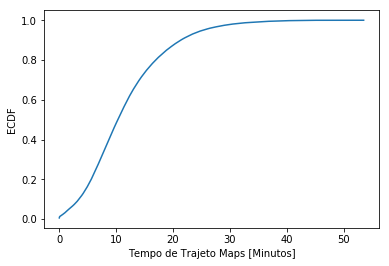

In [37]:
# CDF Maps duration
# Retirando valores entre 0 e 1 do maps

maps = pd.DataFrame()
# maps['duration'] = Occupied_Diff[Occupied_Diff['maps_duration'] >= 0]['maps_duration']
maps['duration'] = Occupied_Diff['maps_duration']

x1, y1 = cdf(maps[maps['duration'] > 0].sort_values(by=['duration']))

fig, ax = plt.subplots()

ax.set_ylabel('ECDF')
ax.set_xlabel('Tempo de Trajeto Maps [Minutos]')

plt.plot(x1, y1)

# plt.savefig('CDF_Maps.pdf', bbox_inches='tight')

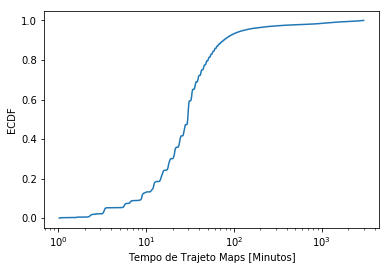

In [25]:
# CDF Ocupação de carros normais
fig, ax = plt.subplots()

ax.set_ylabel('ECDF')
ax.set_xlabel('Tempo de Trajeto Maps [Minutos]')

plt.xscale('log')
x, y = cdf(Occupied_Diff.sort_values(by=['duration']))
plt.plot(x,y)

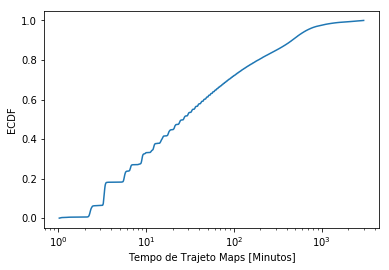

In [26]:
# CDF Viagens de carros normais
fig, ax = plt.subplots()

ax.set_ylabel('ECDF')
ax.set_xlabel('Tempo de Trajeto Maps [Minutos]')

plt.xscale('log')

x, y = cdf(Parked_Diff.sort_values(by='duration'))
plt.plot(x,y)

In [ ]:
# Lendo dados após fitting

ocioso_pareto = pd.read_csv('ocioso_pareto.csv', usecols=[1,2])
ocioso_weibull = pd.read_csv('ocioso_weibull.csv', usecols=[1,2])
ocupado_pareto = pd.read_csv('ocupado_pareto.csv', usecols=[1,2])
ocupado_weibull = pd.read_csv('ocupado_weibull.csv', usecols=[1,2])

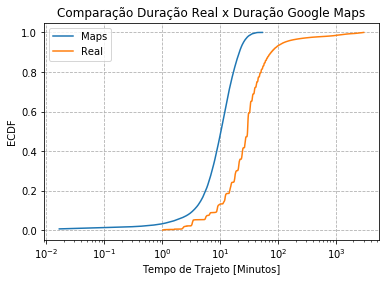

In [39]:
# Comparação maps e tempo real em minutos e escala logaritma

x, y = cdf(Occupied_Diff.sort_values(by=['duration']))

plt.title('Comparação Duração Real x Duração Google Maps')

plt.xscale('log')

plt.grid(b=True, linestyle='--')

# horizontal = [0.5 for i in range(len(x))]
# plt.plot(range(len(x)), horizontal, '--')

# vertical = []
# plt.plot()

plt.ylabel('ECDF')
plt.xlabel('Tempo de Trajeto [Minutos]')

plt.plot(x1,y1, label='Maps')
plt.plot(x,y, label='Real')

plt.legend()

plt.show()
# plt.savefig('maps_real_comparacao.pdf', bbox_inches='tight')

In [45]:
def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    miles = km *  0.621371
    return miles

In [47]:
distance = []
for i in range(len(dfOccupied)):
    distance.append(haversine(dfOccupied['Start_lon'].iloc[i],dfOccupied['Start_lat'].iloc[i],
                              dfOccupied['End_lon'].iloc[i],dfOccupied['End_lat'].iloc[i]))
dfOccupied['distance'] = distance

In [49]:
dfOccupied['distance'] = dfOccupied['distance'] * 1609.34
dfOccupied.tail()

,Start_time,End_time,Id,Start_lat,Start_lon,End_lat,End_lon,Maps_duration,Real_duration,Fuel_start,Fuel_end,distance
1003243,2018-06-19 06:54:31.062817,2018-06-19 07:08:55.810276,JTDKDTB33G1118988,49.283020,-123.111565,49.246296,-123.122948,14.133333,14.412458,29,29,4163.603379
1003244,2018-06-19 06:54:31.062817,2018-06-19 07:08:55.810276,JTDKDTB34H1598685,49.279423,-123.118553,49.266388,-123.103546,8.150000,14.412458,60,54,1811.642816
1003245,2018-06-19 06:56:53.037373,2018-06-19 07:08:55.810276,JTDKDTB38H1598771,49.272100,-123.207123,49.272100,-123.207123,0.000000,14.412458,84,84,0.000000
1003246,2018-06-19 07:00:09.229081,2018-06-19 07:08:55.810276,JTDKDTB39H1597452,49.275684,-123.057640,49.261795,-123.068031,6.766667,12.046215,76,75,1717.542461
1003247,2018-06-19 07:03:30.891967,2018-06-19 07:08:55.810276,JTDKDTB36G1589050,49.246758,-123.069107,49.225700,-123.078751,7.733333,8.776353,80,80,2442.396130


In [62]:
dfGreatDistance = dfOccupied[(dfOccupied['distance'] > 100) & (dfOccupied['Real_duration'] <3000)]

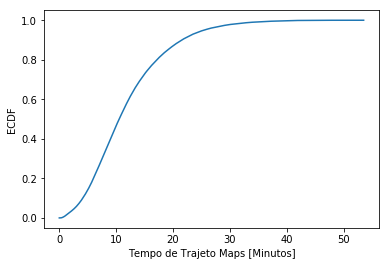

In [63]:
# CDF Maps duration
# Retirando valores entre 0 e 1 do maps

maps = pd.DataFrame()
# maps['duration'] = Occupied_Diff[Occupied_Diff['maps_duration'] >= 0]['maps_duration']
maps['duration'] = dfGreatDistance['Maps_duration']

x1, y1 = cdf(maps[maps['duration'] > 0].sort_values(by=['duration']))

fig, ax = plt.subplots()

ax.set_ylabel('ECDF')
ax.set_xlabel('Tempo de Trajeto Maps [Minutos]')

plt.plot(x1, y1)

# plt.savefig('CDF_Maps.pdf', bbox_inches='tight')

/home/victor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


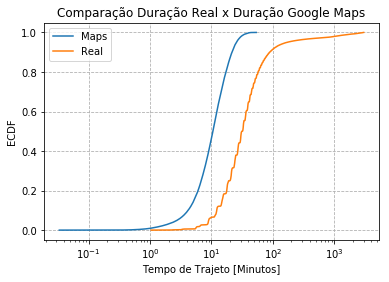

In [64]:
# Comparação maps e tempo real em minutos e escala logaritma
dfGreatDistance['duration'] = dfGreatDistance['Real_duration']
x, y = cdf(dfGreatDistance.sort_values(by=['duration']))

plt.title('Comparação Duração Real x Duração Google Maps')

plt.xscale('log')

plt.grid(b=True, linestyle='--')

# horizontal = [0.5 for i in range(len(x))]
# plt.plot(range(len(x)), horizontal, '--')

# vertical = []
# plt.plot()

plt.ylabel('ECDF')
plt.xlabel('Tempo de Trajeto [Minutos]')

plt.plot(x1,y1, label='Maps')
plt.plot(x,y, label='Real')

plt.legend()

plt.show()
# plt.savefig('maps_real_comparacao.pdf', bbox_inches='tight')

## Tarde e noite para dias de semana

In [ ]:
tarde = []
noite = []

for i in range(len(Occupied_Diff)):
    start = Occupied_Diff['Start_time'].iloc[i]
    hora = start.hour
    dia = int(start.strftime('%w'))
    
    if ((hora >= 11 and hora <= 13) and (dia > 0  and dia < 6)):
        tarde.append([Occupied_Diff['Id'].iloc[i], Occupied_Diff['Start_time'].iloc[i], 
                      Occupied_Diff['duration'].iloc[i]])
    elif ((hora >= 18 and hora <= 19) and (dia > 0  and dia < 6)):
        noite.append([Occupied_Diff['Id'].iloc[i], Occupied_Diff['Start_time'].iloc[i], 
                      Occupied_Diff['duration'].iloc[i]])

tarde = pd.DataFrame(tarde, columns=['car_id', 'start', 'duration'])
noite = pd.DataFrame(noite, columns=['car_id', 'start', 'duration'])

In [ ]:
# Durações menores que 66 horas
tarde = tarde[tarde['duration'] < 4000]
noite = noite[noite['duration'] < 4000]

In [ ]:
x, y = cdf(tarde.sort_values(by='duration'))
plt.plot(x,y)

In [ ]:
x, y = cdf(noite.sort_values(by='duration'))
plt.plot(x,y)

In [ ]:
# Durações menores ou iguais que 28 horas
tarde = tarde[tarde['duration'] <= 28*60]
noite = noite[noite['duration'] <= 28*60]
todos = Occupied_Diff[Occupied_Diff['duration'] <= 28*60]

In [ ]:
import matplotlib

matplotlib.rc('font', size=12)

fig, ax = plt.subplots()

x, y = cdf(tarde.sort_values(by='duration'))
ax.plot(x,y, label='11h a 13h')# marker='o', markevery=[30,140,280,400,580,800,960,1010,1100])

x, y = cdf(noite.sort_values(by='duration'))
ax.plot(x,y, label='18h a 19h') #marker='s', markevery=[30,60,120,190,280,340,392,400,406])

x, y = cdf(todos.sort_values(by='duration'))
ax.plot(x,y, label='Dia todo') #marker='^', markevery=[20,120,350,600,960,1400,2200,2800,3600,4300,4550])

# Modificando os labels dos minutos
ax.xaxis.set_ticks(np.arange(0, 1800, 180))

fig.canvas.draw()

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = range(0,30,3)

ax.set_xticklabels(labels)

ax.legend(bbox_to_anchor=(0.65, 0.3), loc=2, borderaxespad=0.2)
ax.set_ylabel('ECDF')
ax.set_xlabel('Tempo Ocupado [horas]')

# plt.savefig('tarde_noiteCDF.pdf')